In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from IPython.display import display

np.random.seed(1000)

n_branches = 600
start_date = pd.Timestamp('2025-04-01')
end_date = pd.Timestamp('2025-07-31')
date_range = pd.date_range(start=start_date, end=end_date)

branch_ids = [f"B{i:04d}" for i in range(n_branches)]

pilot_branches = np.random.choice(branch_ids, size=50, replace=False)
pilot_june = pilot_branches[:25]
pilot_july = pilot_branches[25:]
pilot_info = {b: pd.Timestamp('2025-06-01') for b in pilot_june}
pilot_info.update({b: pd.Timestamp('2025-07-01') for b in pilot_july})

records = []
for branch in branch_ids:
    is_pilot = int(branch in pilot_info)
    pilot_start = pilot_info.get(branch)
    for date in date_range:
        lam = 180 if is_pilot else 178
        base_att = np.random.poisson(lam)
        noise_att = np.random.normal(0, 15)
        n_att = max(20, int(base_att + noise_att))
        base_wait = np.random.normal(10, 2)
        is_after = pilot_start is not None and date >= pilot_start
        effect = 1.5 if is_after else 0.0
        avg_wait = max(0, base_wait + effect + np.random.normal(0, 1))
        deposit_vol = max(0, n_att * np.random.normal(1.2, 0.2))
        records.append({
            'date': date,
            'branch_id': branch,
            'is_pilot': is_pilot,
            'pilot_start': pilot_start,
            'n_attendances': n_att,
            'avg_wait_time': round(avg_wait, 2),
            'atm_deposit_volume': round(deposit_vol, 2)
        })

df = pd.DataFrame(records)

In [2]:
df.head()

,date,branch_id,is_pilot,pilot_start,n_attendances,avg_wait_time,atm_deposit_volume
0,2025-04-01,B0000,0,NaT,171,10.85,212.32
1,2025-04-02,B0000,0,NaT,154,8.67,191.25
2,2025-04-03,B0000,0,NaT,202,8.56,302.84
3,2025-04-04,B0000,0,NaT,152,10.34,216.31
4,2025-04-05,B0000,0,NaT,183,11.34,236.31


In [3]:
df[df['is_pilot']==1]

,date,branch_id,is_pilot,pilot_start,n_attendances,avg_wait_time,atm_deposit_volume
1708,2025-04-01,B0014,1,2025-06-01,162,11.23,222.11
1709,2025-04-02,B0014,1,2025-06-01,178,9.90,160.13
1710,2025-04-03,B0014,1,2025-06-01,200,8.51,242.32
1711,2025-04-04,B0014,1,2025-06-01,183,8.47,214.04
1712,2025-04-05,B0014,1,2025-06-01,185,9.00,205.06
...,...,...,...,...,...,...,...
71487,2025-07-27,B0585,1,2025-07-01,201,11.01,292.50
71488,2025-07-28,B0585,1,2025-07-01,165,11.76,219.19
71489,2025-07-29,B0585,1,2025-07-01,201,15.97,299.53
71490,2025-07-30,B0585,1,2025-07-01,197,11.27,256.65


In [6]:
def compute_baseline_covariates(
    df: pd.DataFrame,
    pilot_info: dict,
    covariates: list,
    window_days: int = 60
) -> pd.DataFrame:
    """
    Computa médias dos covariáveis de linha de base (pré-intervenção) para cada agência,
    considerando apenas os `window_days` dias imediatamente anteriores ao início do piloto.
    
    Para agências tratadas: janela = [pilot_start - window_days, pilot_start).
    Para agências de controle: janela = [earliest_start - window_days, earliest_start),
    onde earliest_start = menor data de início de piloto entre todas as agências tratadas.
    
    Retorna um DataFrame indexado por branch_id com uma linha por agência.
    """
    # menor data de início entre todos os pilotos (para controles)
    earliest_start = min(pilot_info.values())
    registros = []
    
    for branch, grp in df.groupby('branch_id'):
        # data de corte é o início do piloto desta agência, ou earliest_start se for controle
        cutoff = pilot_info.get(branch, earliest_start)
        start_window = cutoff - pd.Timedelta(days=window_days)
        
        # filtra apenas as datas na janela [start_window, cutoff)
        mask = (grp['date'] >= start_window) & (grp['date'] < cutoff)
        janela_df = grp.loc[mask, covariates]
        
        medias = janela_df.mean()
        medias['branch_id'] = branch
        registros.append(medias)
    
    baseline_df = pd.DataFrame.from_records(registros).set_index('branch_id')
    return baseline_df

def match_with_replacement(
    baseline_df: pd.DataFrame,
    treated_ids: list,
    n_controls: int = 3
) -> dict:
    """
    Para cada agência tratada, seleciona os `n_controls` controles mais próximos
    no espaço padronizado de covariáveis, **com** reposição (ou seja, uma mesma
    agência de controle pode ser atribuída a vários tratamentos).
    
    Retorna dict: {tratada: [controle1, controle2, controle3], ...}
    """
    # índices de possíveis controles
    control_index = baseline_df.drop(index=treated_ids).index
    
    # padroniza em todo o conjunto (tratadas + controles)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(baseline_df)
    scaled_df = pd.DataFrame(scaled, index=baseline_df.index, columns=baseline_df.columns)
    
    matches = {}
    for trat in treated_ids:
        # diferenças e distâncias até todos os controles
        diffs = scaled_df.loc[control_index] - scaled_df.loc[trat]
        dists = np.linalg.norm(diffs.values, axis=1)
        
        # pega os índices dos menores valores
        nearest_idx = np.argsort(dists)[:n_controls]
        escolhidos = [control_index[i] for i in nearest_idx]
        
        matches[trat] = escolhidos
    
    return matches


In [7]:
covariate_cols = ['n_attendances', 'avg_wait_time', 'atm_deposit_volume']

#calcula médias de baseline para cada agência, nos 60 dias antes do piloto
baseline_df = compute_baseline_covariates(df, pilot_info, covariate_cols, window_days=60)

#lista de agências tratadas (as chaves de pilot_info)
treated_branches = list(pilot_info.keys())

#roda matching **com** reposição
matched = match_with_replacement(baseline_df, treated_branches, n_controls=3)

#imprime resultados
for trat, ctrls in matched.items():
    print(f"Tratada {trat} → Controles: {', '.join(ctrls)}")

Tratada B0438 → Controles: B0363, B0473, B0178
Tratada B0346 → Controles: B0404, B0587, B0295
Tratada B0486 → Controles: B0550, B0445, B0262
Tratada B0136 → Controles: B0135, B0445, B0345
Tratada B0481 → Controles: B0215, B0404, B0587
Tratada B0132 → Controles: B0193, B0304, B0428
Tratada B0368 → Controles: B0508, B0495, B0331
Tratada B0422 → Controles: B0472, B0441, B0204
Tratada B0043 → Controles: B0249, B0100, B0128
Tratada B0573 → Controles: B0128, B0204, B0504
Tratada B0484 → Controles: B0056, B0142, B0384
Tratada B0177 → Controles: B0146, B0482, B0218
Tratada B0570 → Controles: B0173, B0381, B0083
Tratada B0168 → Controles: B0066, B0457, B0581
Tratada B0079 → Controles: B0384, B0542, B0142
Tratada B0528 → Controles: B0433, B0116, B0253
Tratada B0399 → Controles: B0331, B0508, B0519
Tratada B0014 → Controles: B0555, B0469, B0577
Tratada B0248 → Controles: B0018, B0105, B0552
Tratada B0061 → Controles: B0495, B0200, B0508
Tratada B0406 → Controles: B0042, B0087, B0592
Tratada B0060

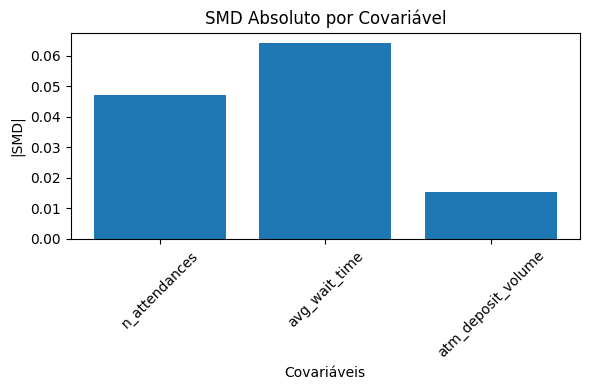

In [10]:
#Preparar lista de controles (com repetição, pois matching foi com reposição)
controls_all = []
for tr, ctrls in matched.items():
    controls_all.extend(ctrls)

#Calcular SMD (Standardized Mean Difference) para cada covariável
records = []
for cov in baseline_df.columns:
    treat_vals = baseline_df.loc[treated_branches, cov]
    control_vals = baseline_df.loc[controls_all, cov]
    
    m1, m2 = treat_vals.mean(), control_vals.mean()
    v1, v2 = treat_vals.var(ddof=1), control_vals.var(ddof=1)
    n1, n2 = len(treat_vals), len(control_vals)
    
    pooled_sd = np.sqrt(((n1 - 1)*v1 + (n2 - 1)*v2) / (n1 + n2 - 2))
    smd = (m1 - m2) / pooled_sd
    
    records.append({
        'covariável': cov,
        'média_tratadas': m1,
        'média_controles': m2,
        'SMD': smd
    })

summary_df = pd.DataFrame(records).set_index('covariável')


# plot simples (barras do SMD absoluto)
plt.figure(figsize=(6,4))
plt.bar(summary_df.index, summary_df['SMD'].abs())
plt.ylabel('|SMD|')
plt.xlabel('Covariáveis')
plt.title('SMD Absoluto por Covariável')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
#Criar lista de pares (branch, pilot_associado)
pares = []
for piloto, controles in matched.items():
    # inclui a própria agência piloto
    pares.append((piloto, piloto))
    # inclui cada controle atrelado ao piloto
    for ctrl in controles:
        pares.append((ctrl, piloto))

# Construir o DataFrame final
lista_dfs = []
for branch, piloto in pares:
    temp = df[df['branch_id'] == branch].copy()
    # selecionar apenas colunas essenciais
    temp = temp[['date', 'branch_id', 'n_attendances', 'avg_wait_time', 'atm_deposit_volume']]
    # sinalizar papel e piloto associado
    temp['role'] = np.where(temp['branch_id'] == piloto, 'pilot', 'control')
    temp['pilot_id'] = piloto
    # data de início do piloto correspondente
    temp['pilot_start'] = pilot_info[piloto]
    # delta entre data do registro e data de início do piloto
    temp['delta_days'] = (temp['date'] - temp['pilot_start']).dt.days
    lista_dfs.append(temp)

final_df = pd.concat(lista_dfs, ignore_index=True)

In [17]:
final_df.head()

,date,branch_id,n_attendances,avg_wait_time,atm_deposit_volume,role,pilot_id,pilot_start,delta_days
0,2025-04-01,B0438,185,8.41,181.43,pilot,B0438,2025-06-01,-61
1,2025-04-02,B0438,214,9.86,299.72,pilot,B0438,2025-06-01,-60
2,2025-04-03,B0438,178,6.41,248.88,pilot,B0438,2025-06-01,-59
3,2025-04-04,B0438,198,9.30,250.64,pilot,B0438,2025-06-01,-58
4,2025-04-05,B0438,180,8.78,174.31,pilot,B0438,2025-06-01,-57
